In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [185]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [216]:
tf.keras.backend.set_floatx("float64")

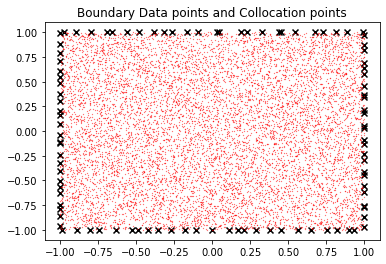

In [217]:
### data generation
n_bc = 4
n_data_per_bc = 25
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 3])

for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j

# BC Values
# normalized in [0, 1]
data[0, :, 2] = 1.
data[2, :, 2] = 50/75

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

#

Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5)
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [218]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

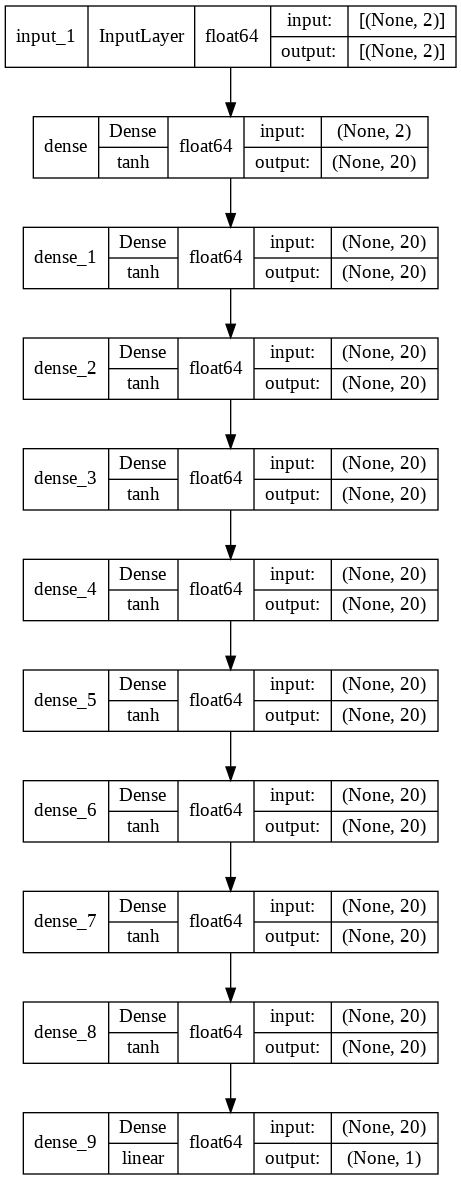

In [219]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 9, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

In [220]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [221]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = u_xx + u_yy
    return tf.reduce_mean(tf.square(F))

In [222]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 0.545
  200, 0.045
  400, 0.032
  600, 0.021
  800, 0.020
  999, 0.019

computation time: 66.354



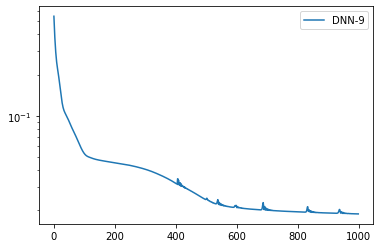

In [223]:
loss = 0
epochs = 1000
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = l+L
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.3f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [224]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

In [225]:
B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T = np.matmul(np.linalg.inv(T), b)
T = T.reshape([n, n])
Temperature = T
end = time.time()
computation_time["fdm"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")


computation time: 77.599



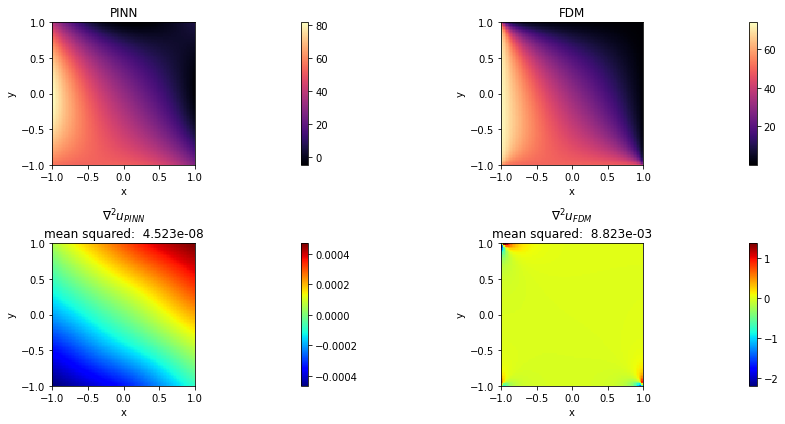

In [231]:
### plotting
plt.figure("", figsize=(12, 6))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(222)
plt.pcolormesh(x, y, T, cmap="magma")
plt.colorbar()
plt.title(r"FDM")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
#
plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"${\nabla^{2}{u_{PINN}}}$" + f"\nmean squared: {sigma_pinn: .3e}")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(224)
fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
sigma_fdm = (fdm_grad**2).mean()
plt.pcolormesh(x, y, fdm_grad, cmap="jet")
plt.colorbar()
plt.title(r"${\nabla^{2}{u_{FDM}}}$" + f"\nmean squared: {sigma_fdm: .3e}")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
plt.show()

In [227]:
print("performance comparison".center(26))
print("="*26)
for method in computation_time:
    print(f"{method}\t\t{computation_time[method]:6.2f} (s)")

  performance comparison  
pinn		 66.35 (s)
fdm		 77.60 (s)


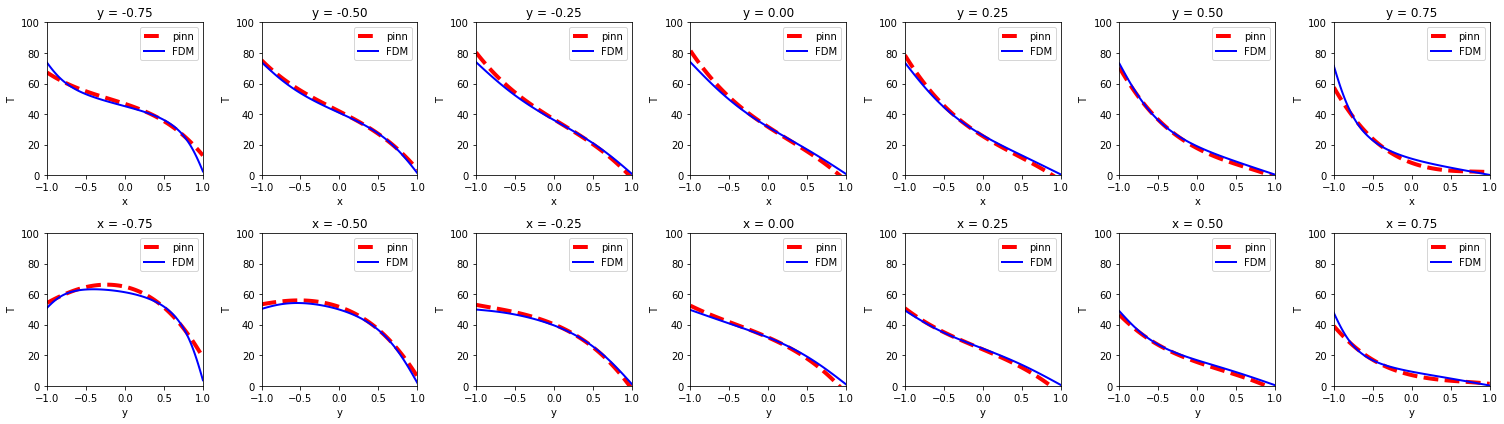

In [232]:
S_ = S.reshape([n, n])
T_ = T.reshape([n, n])

height = 3
frames_val = np.array([-.75, -.5, -.25, 0., +.25, +.5, +.75])
frames = [*map(int, (frames_val + 1)/2 * (n-1))]
fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}")
    plt.plot(X0[var_index, :], 75.*S_[var_index,:], "r--", lw=4., label="pinn")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="FDM")
    plt.ylim(0., 100.)
    plt.xlim(-1., +1.)
    plt.xlabel("x")
    plt.ylabel("T")
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}")
    plt.plot(Y0[:, var_index], 75.*S_[:,var_index], "r--", lw=4., label="pinn")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="FDM")
    plt.ylim(0., 100.)
    plt.xlim(-1., +1.)
    plt.xlabel("y")
    plt.ylabel("T")
    plt.tight_layout()
    plt.legend()

plt.savefig("profiles.png")
plt.show()

In [229]:
model.save("heat-man.h5")

In [230]:
! cp heat-man.h5 drive/MyDrive